# Visualize Parity between BMTK and BrainLGN-X

This notebook compares outputs from BMTK's LNUnit and BrainLGN-X's LGNNeuron on the same stimulus and filter stack.
It overlays rate time series, plots residuals, and reports numerical metrics (MAE/RMSE/MaxAbs/Corr).

In [1]:
import os, sys, numpy as np, matplotlib.pyplot as plt

# Ensure package root on path (adjust if running from elsewhere)
PKG_ROOT = os.path.abspath(os.path.join('..'))
if PKG_ROOT not in sys.path: sys.path.insert(0, PKG_ROOT)

from brainlgn_x.neuron import LGNNeuron
from brainlgn_x.filters import GaussianSpatialFilter, TemporalFilterCosineBump, SpatioTemporalFilter
from brainlgn_x.transfer import ScalarTransferFunction

from bmtk.simulator.filternet.lgnmodel.lnunit import LNUnit
from bmtk.simulator.filternet.lgnmodel.movie import Movie

In [2]:
def build_components(amplitude=1.0, bias=0.0):
    spatial = GaussianSpatialFilter(translate=(0.0, 0.0), sigma=(2.0, 2.0))
    tfilt   = TemporalFilterCosineBump(weights=(0.4, -0.3), kpeaks=(20.0, 60.0), delays=(0, 0))
    st      = SpatioTemporalFilter(spatial, tfilt, amplitude=float(amplitude))
    # Use Max to avoid two-arg Heaviside signature issues
    xfer    = ScalarTransferFunction(f'Max(0, s + {bias})')
    return st, xfer

## Generate stimulus and compute outputs (separable path)

In [3]:
# Parameters
rng = np.random.RandomState(0)
T, H, W = 10000, 16, 16
frame_rate = 1000.0  # Hz
stim = rng.randn(T, H, W) * 0.05  # random stimulus

# Build filters
st, xfer = build_components(amplitude=1.0, bias=0.0)

# BMTK reference (separable)
movie  = Movie(stim, frame_rate=frame_rate)
ln_ref = LNUnit(st, xfer)
t_ref, y_ref = ln_ref.get_cursor(movie, separable=True).evaluate()
y_ref = np.array(y_ref)

# BrainLGN-X
neuron = LGNNeuron(spatial_filter=st.spatial_filter, temporal_filter=st.temporal_filter,
                   transfer_function=xfer, amplitude=st.amplitude)
y_new = neuron.evaluate(stim, separable=True, frame_rate=frame_rate)

# Metrics
diff = y_new - y_ref
mae  = np.mean(np.abs(diff))
rmse = np.sqrt(np.mean(diff**2))
mx   = np.max(np.abs(diff))
corr = np.corrcoef(y_ref, y_new)[0,1]
print(f'MAE={mae:.3e}, RMSE={rmse:.3e}, MaxAbs={mx:.3e}, Corr={corr:.6f}')

MAE=0.000e+00, RMSE=0.000e+00, MaxAbs=0.000e+00, Corr=1.000000


## Plots: overlay, residual, scatter, histogram

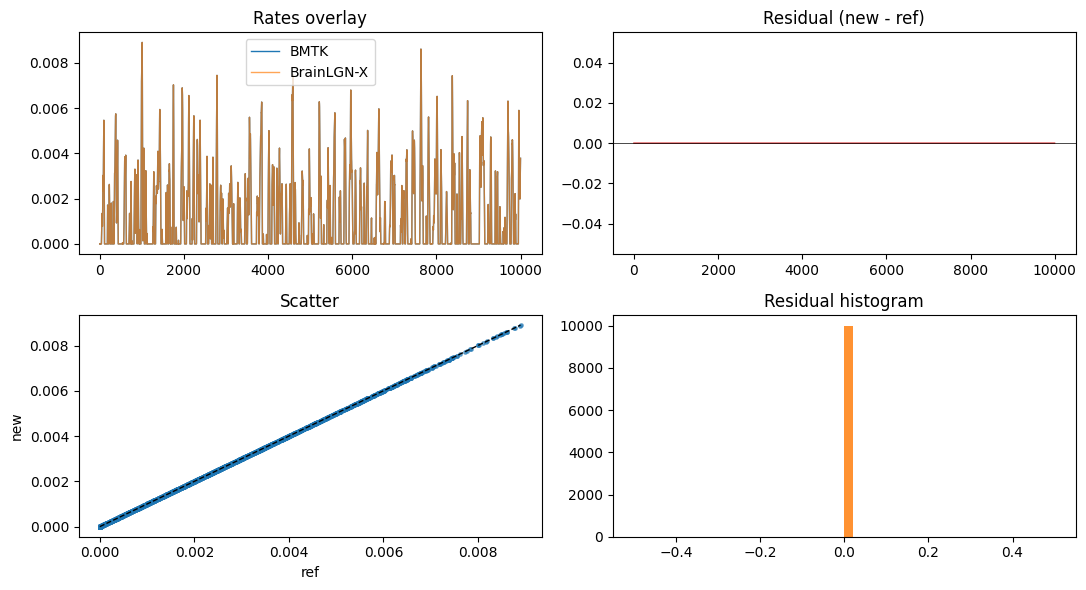

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(11, 6))
axs = axs.ravel()

axs[0].plot(y_ref, label='BMTK', lw=1)
axs[0].plot(y_new, label='BrainLGN-X', lw=1, alpha=0.7)
axs[0].set_title('Rates overlay'); axs[0].legend()

axs[1].plot(diff, lw=1, color='C3')
axs[1].axhline(0, color='k', lw=0.5)
axs[1].set_title('Residual (new - ref)')

axs[2].scatter(y_ref, y_new, s=6, alpha=0.6)
m = float(max(y_ref.max(), y_new.max()))
axs[2].plot([0, m], [0, m], 'k--', lw=1)
axs[2].set_xlabel('ref'); axs[2].set_ylabel('new'); axs[2].set_title('Scatter')

axs[3].hist(diff, bins=50, color='C1', alpha=0.85)
axs[3].set_title('Residual histogram')

plt.tight_layout(); plt.show()

## Optional: non-separable path comparison

Non-separable: MAE=0.000e+00, RMSE=0.000e+00, MaxAbs=0.000e+00


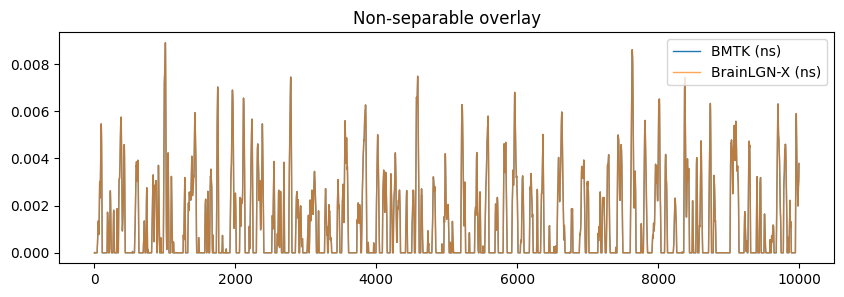

In [5]:
movie_ns  = Movie(stim, frame_rate=frame_rate)
ln_ref_ns = LNUnit(st, xfer)
t_ns, y_ref_ns = ln_ref_ns.get_cursor(movie_ns, separable=False, threshold=0.0).evaluate(downsample=1)
y_ref_ns = np.array(y_ref_ns)

y_new_ns = neuron.evaluate(stim, separable=False, threshold=0.0, downsample=1, frame_rate=frame_rate)
diff_ns  = y_new_ns - y_ref_ns
print('Non-separable: MAE=%.3e, RMSE=%.3e, MaxAbs=%.3e' % (
    np.mean(np.abs(diff_ns)), np.sqrt(np.mean(diff_ns**2)), np.max(np.abs(diff_ns))
))

plt.figure(figsize=(10,3))
plt.plot(y_ref_ns, label='BMTK (ns)', lw=1)
plt.plot(y_new_ns, label='BrainLGN-X (ns)', lw=1, alpha=0.7)
plt.legend(); plt.title('Non-separable overlay'); plt.show()

## Are we using JAX/BrainState right now?

Currently, LGNNeuron.evaluate() calls into BMTK's LNUnit + Cursor under-the-hood to guarantee exact numerical parity.
Therefore, JAX/BrainState is not used in the compute path yet (imports are optional).
Once a BrainState backend is wired, rerun this notebook to compare performance.

## Runtime Benchmark (separable and non-separable)

In [6]:
import time, gc, statistics as stats

def bench(fn, repeats=5, warmup=1):
    for _ in range(max(0, warmup)):
        fn()
    times = []
    for _ in range(repeats):
        gc.collect()
        t0 = time.perf_counter()
        _ = fn()
        times.append(time.perf_counter() - t0)
    return {
        'mean': stats.mean(times),
        'stdev': (stats.pstdev(times) if len(times)>1 else 0.0),
        'min': min(times),
        'max': max(times),
        'n': len(times),
        'raw': times,
    }

# Prepare callables (separable)
bmtk_sep = lambda: LNUnit(st, xfer).get_cursor(Movie(stim, frame_rate=frame_rate), separable=True).evaluate()
ours_sep = lambda: LGNNeuron(st.spatial_filter, st.temporal_filter, xfer, amplitude=st.amplitude).evaluate(
    stim, separable=True, frame_rate=frame_rate
)

res_bmtk_sep = bench(bmtk_sep, repeats=5, warmup=1)
res_ours_sep = bench(ours_sep, repeats=5, warmup=1)
print('Separable  BMTK  :', res_bmtk_sep)
print('Separable  Ours  :', res_ours_sep)

# Prepare callables (non-separable)
bmtk_ns = lambda: LNUnit(st, xfer).get_cursor(Movie(stim, frame_rate=frame_rate), separable=False, threshold=0.0).evaluate(downsample=1)
ours_ns = lambda: LGNNeuron(st.spatial_filter, st.temporal_filter, xfer, amplitude=st.amplitude).evaluate(
    stim, separable=False, threshold=0.0, downsample=1, frame_rate=frame_rate
)

res_bmtk_ns = bench(bmtk_ns, repeats=3, warmup=1)
res_ours_ns = bench(ours_ns, repeats=3, warmup=1)
print('Non-sep    BMTK  :', res_bmtk_ns)
print('Non-sep    Ours  :', res_ours_ns)

# Note: For now, our evaluate() delegates to BMTK, so timings should be similar except for minor wrapper overhead.
# Once a BrainState backend is integrated, re-run to compare real differences (and consider JIT warm-up).

Separable  BMTK  : {'mean': 0.029153480002423748, 'stdev': 0.0013103508143467268, 'min': 0.027613800019025803, 'max': 0.03101730000344105, 'n': 5, 'raw': [0.03037739999126643, 0.02823039999930188, 0.027613800019025803, 0.03101730000344105, 0.02852849999908358]}
Separable  Ours  : {'mean': 0.027523299999302253, 'stdev': 0.0036374267133501546, 'min': 0.02479900000616908, 'max': 0.03460330000962131, 'n': 5, 'raw': [0.027014899998903275, 0.02479900000616908, 0.02491159999044612, 0.03460330000962131, 0.026287699991371483]}
Non-sep    BMTK  : {'mean': 9.729036599999139, 'stdev': 0.43176608656833093, 'min': 9.336685599992052, 'max': 10.330401499988511, 'n': 3, 'raw': [9.336685599992052, 9.520022700016852, 10.330401499988511]}
Non-sep    Ours  : {'mean': 10.063651000004029, 'stdev': 0.5356888164336544, 'min': 9.648957400000654, 'max': 10.82005670000217, 'n': 3, 'raw': [9.721938900009263, 9.648957400000654, 10.82005670000217]}


## BrainState (JAX) backend parity & timing (separable only)

BS separable parity: MAE=2.166e-10, RMSE=3.868e-10, MaxAbs=2.299e-09, Corr=1.000000


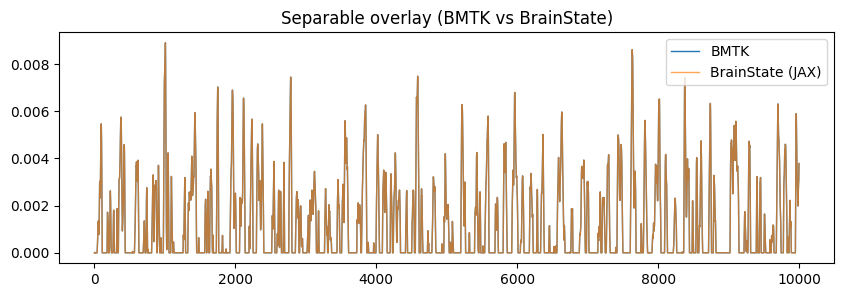

In [7]:
# Compute with BrainState backend (separable) and compare numerically
y_bs = LGNNeuron(st.spatial_filter, st.temporal_filter, xfer, amplitude=st.amplitude).evaluate(
    stim, separable=True, frame_rate=frame_rate, backend='brainstate'
)
diff_bs = y_bs - y_ref
print('BS separable parity: MAE=%.3e, RMSE=%.3e, MaxAbs=%.3e, Corr=%.6f' % (
    np.mean(np.abs(diff_bs)), np.sqrt(np.mean(diff_bs**2)), np.max(np.abs(diff_bs)), np.corrcoef(y_ref, y_bs)[0,1]
))

plt.figure(figsize=(10,3))
plt.plot(y_ref, label='BMTK', lw=1)
plt.plot(y_bs, label='BrainState (JAX)', lw=1, alpha=0.7)
plt.legend(); plt.title('Separable overlay (BMTK vs BrainState)'); plt.show()


In [8]:
# Timing BMTK vs BrainState backends (separable)
res_ours_sep_bmtk = bench(lambda: LGNNeuron(st.spatial_filter, st.temporal_filter, xfer, amplitude=st.amplitude).evaluate(
    stim, separable=True, frame_rate=frame_rate, backend='bmtk'
), repeats=5, warmup=1)
res_ours_sep_bs   = bench(lambda: LGNNeuron(st.spatial_filter, st.temporal_filter, xfer, amplitude=st.amplitude).evaluate(
    stim, separable=True, frame_rate=frame_rate, backend='brainstate'
), repeats=5, warmup=1)
print('Separable  Ours (BMTK backend):', res_ours_sep_bmtk)
print('Separable  Ours (BS backend)  :', res_ours_sep_bs)


Separable  Ours (BMTK backend): {'mean': 0.038048319995868954, 'stdev': 0.005277019774410731, 'min': 0.030216399987693876, 'max': 0.043494699988514185, 'n': 5, 'raw': [0.03346649999730289, 0.040313900011824444, 0.043494699988514185, 0.04275009999400936, 0.030216399987693876]}
Separable  Ours (BS backend)  : {'mean': 0.009946479991776868, 'stdev': 0.0013506350323562641, 'min': 0.008994599978905171, 'max': 0.012595300009706989, 'n': 5, 'raw': [0.008995799988042563, 0.008994599978905171, 0.009482499997830018, 0.009664199984399602, 0.012595300009706989]}
